# Patient Clustering Analysis


This notebook performs unsupervised clustering on patient data to identify natural segments based on demographics, lifestyle, and medical history for our medical insurance dataset. 

**Goals:**
1. Preprocess data (handle missing values, scale numerical features, one-hot encode categorical features).
2. Use the elbow method to find the best number of clusters.
3. Apply K-Means clustering to the dataset. 
4. Profile the clusters to understand characteristics of each type of cluster.
5. Validate the clusters using a Random Forest classifier.
6. Create visuals and graphs to report our findings.

In [2]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# load dataset
df = pd.read_csv("medical_insurance.csv")

# handle missing values 
df.replace(["", "NA", "N/A", "NaN", "None"], np.nan, inplace=True)

# check the dimensions of the full dataset
print("Data shape:", df.shape)

Data shape: (100000, 54)


## 1. Feature Selection and Preprocessing

We select specific demographic and health markers for clustering. A `ColumnTransformer` is used to build a robust pipeline that imputes missing data and scales numerical values (essential for K-Means distance calculations).

In [3]:
# these are our features for clustering
cluster_features = [
    # demographic features
    "age", "sex",

    # lifestyle features
    "bmi", "smoker", "alcohol_freq",

    # bp, LDL and glucoseblood sugar
    "systolic_bp", "diastolic_bp", "ldl", "hba1c",

    # amount of chronic conditions
    "chronic_count"
]

# make sure features exist in the original df
cluster_features = [c for c in cluster_features if c in df.columns]

# create the new X features df
X = df[cluster_features].copy()

# separate categorical vs numeric (for pipeline)
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

# preprocessing pipeline
# for numerical (median and scaling operations)
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")), # replace missing values with the median
    ("scaler", StandardScaler()) 
])

# for categorical (most frequent and binarize method)
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")), # replace mmissing values with majority 
    ("ohe", OneHotEncoder(handle_unknown="ignore")) # binarize
])

# output numeric matrix based on above preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, categorical_cols),
        ("num", num_pipe, numeric_cols)
    ]
)

# fit & transform to get matrix for clustering
X_pre = preprocess.fit_transform(X)
print("\nTransformed feature matrix:", X_pre.shape) #checks if our data is correctly processed 


Transformed feature matrix: (100000, 16)


## 2. The Elbow Method

To determine the optimal number of clusters ($k$), we iterate through $k=2$ to $k=10$ and calculate the inertia (sum of squared distances to the nearest cluster center). We look for the "elbow" point where inertia begins to plateau. We analyize this through a graph and pick a value for $k$

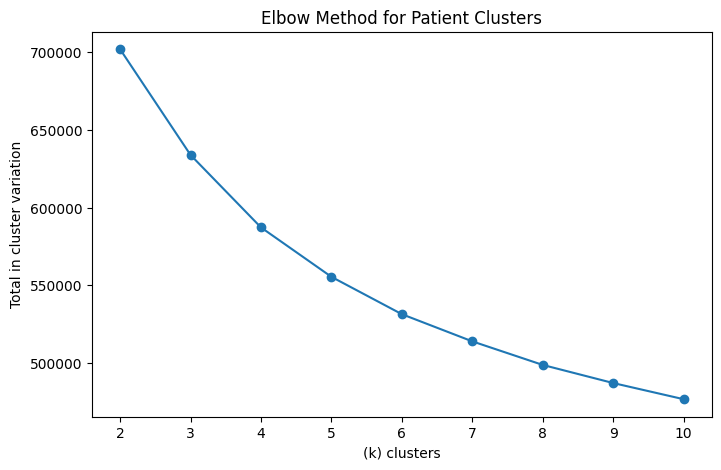

In [4]:
# elbow method to choose k
inertia = [] # list to store inertia values (how far points are cluster center)
k_range = range(2, 11) # range for cluster counts

# try k means (2 to 10) for each k, fit the model and record the inertia
for k in k_range:
    km_tmp = KMeans(n_clusters=k, random_state=100, n_init=10)
    km_tmp.fit(X_pre)
    inertia.append(km_tmp.inertia_)

# use inertia to build elbow plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker="o")
plt.xticks(k_range)
plt.xlabel("(k) clusters")
plt.ylabel("Total in cluster variation")
plt.title("Elbow Method for Patient Clusters")
plt.show()

## 3. Clustering & Profiling

Based on the analysis above, we select $k=4$. We assign cluster labels to the dataframe and calculate the mean values of features for each cluster to understand the "typical" patient in each segment.

In [5]:
# fit final k means model
k_chose = 4 
kmeans = KMeans(n_clusters=k_chose, random_state=100, n_init=20)
labels = kmeans.fit_predict(X_pre)

df["cluster"] = labels

print("\nCluster sizes:")
print(df["cluster"].value_counts().sort_index())

# calculate in cluster averages
# (We can still look at cost & utilization by cluster, even though they weren't used to form the clusters)
profile_vars = cluster_features.copy()

# add cost & utilization (for interpretation only)
for extra in [
    "annual_medical_cost",
    "visits_last_year", "hospitalizations_last_3yrs",
    "days_hospitalized_last_3yrs", "medication_count"
]:
    if extra in df.columns:
        profile_vars.append(extra)

# only keep numeric columns when computing means
cluster_profile = (
    df[profile_vars + ["cluster"]]
    .select_dtypes(include="number")
    .groupby("cluster")
    .mean()
    .round(2)
)

print(cluster_profile)

cluster_profile.to_csv("cluster_profiles_full.csv")
print("see saved csv file!!!")


Cluster sizes:
cluster
0    34858
1    35623
2     6556
3    22963
Name: count, dtype: int64
           age    bmi  systolic_bp  diastolic_bp     ldl  hba1c  \
cluster                                                           
0        55.66  26.99       119.52         72.49  132.37   5.41   
1        33.98  26.96       105.49         68.62  108.40   5.42   
2        49.68  27.09       118.39         73.62  120.69   8.25   
3        55.57  27.01       134.15         83.02  118.91   5.44   

         chronic_count  annual_medical_cost  visits_last_year  \
cluster                                                         
0                 0.34              2719.21              1.54   
1                 0.42              2429.14              1.62   
2                 1.67              4104.77              2.88   
3                 1.51              4037.58              2.73   

         hospitalizations_last_3yrs  days_hospitalized_last_3yrs  \
cluster                                     

## 4. Visualizing Costs and Risk Factors

We visualize the relationship between the derived clusters and key business metrics like `annual_medical_cost`.


Cost by cluster:
             n  avg_cost   total_cost  cost_share_%
cluster                                            
0        34858   2719.21  94786129.11         31.50
1        35623   2429.14  86533178.55         28.75
2         6556   4104.77  26910902.59          8.94
3        22963   4037.58  92714980.45         30.81


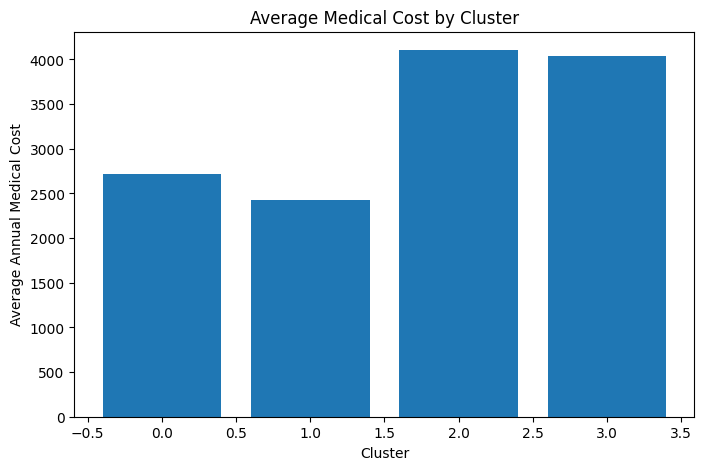

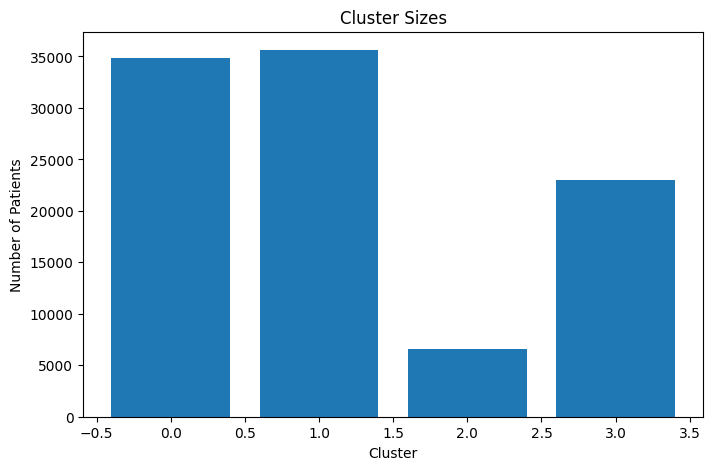

<Figure size 700x400 with 0 Axes>

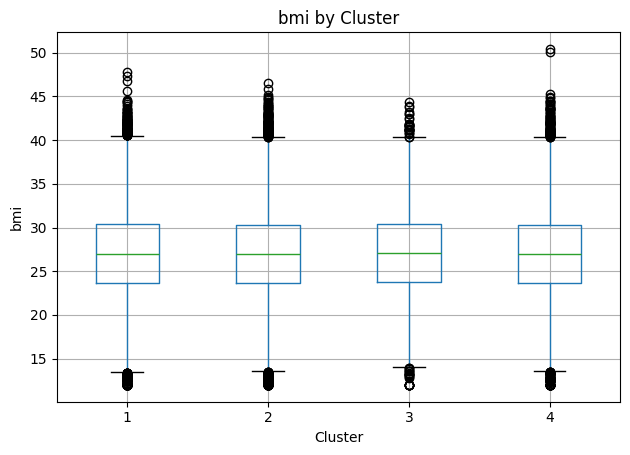

<Figure size 700x400 with 0 Axes>

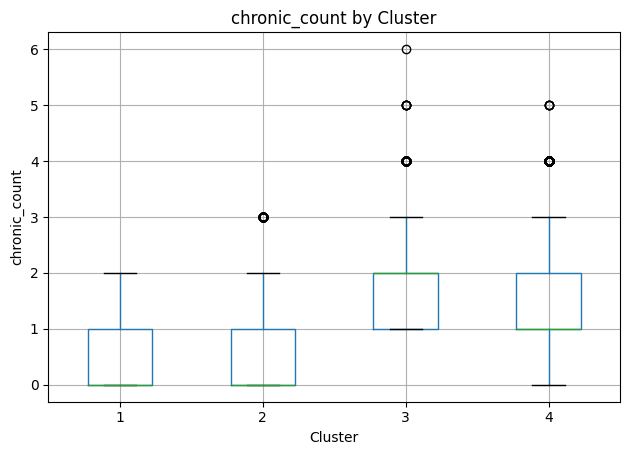

<Figure size 700x400 with 0 Axes>

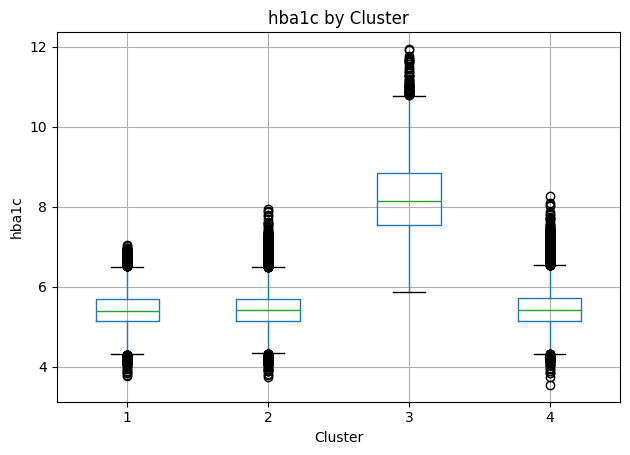

<Figure size 700x400 with 0 Axes>

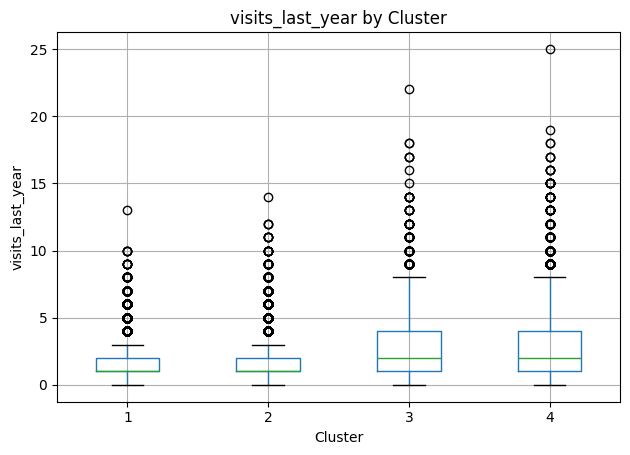

<Figure size 700x400 with 0 Axes>

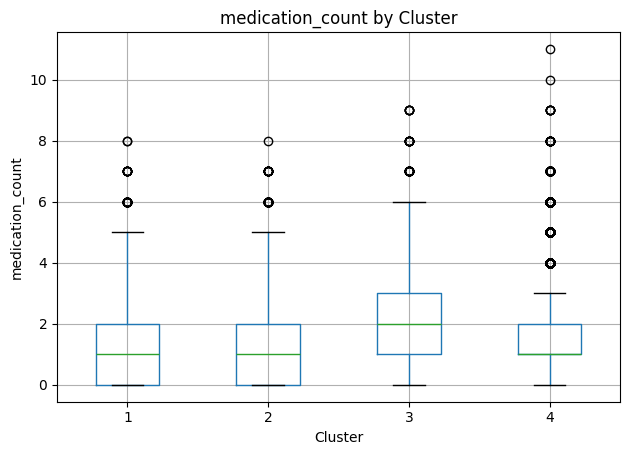

<Figure size 700x400 with 0 Axes>

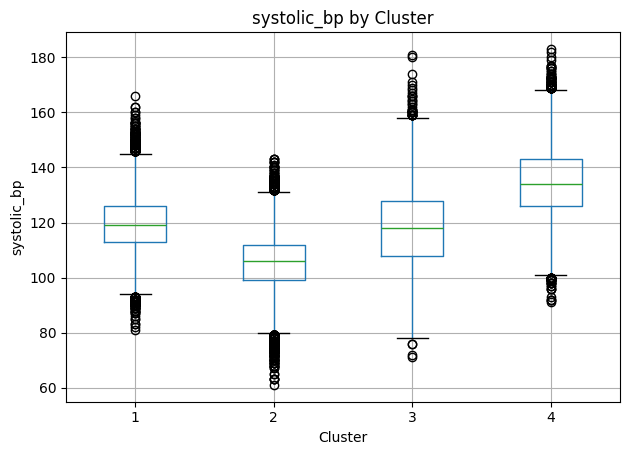

<Figure size 700x400 with 0 Axes>

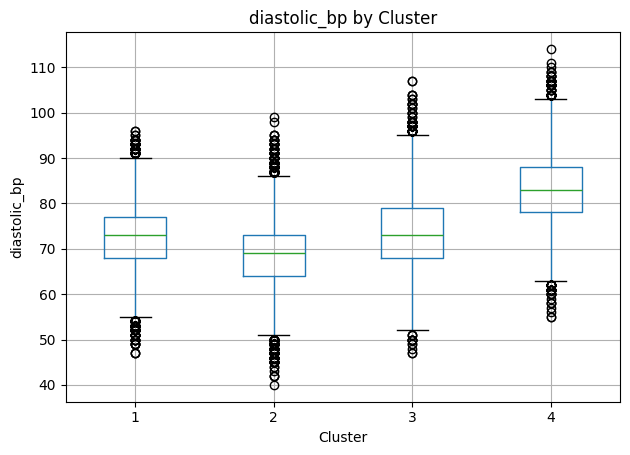

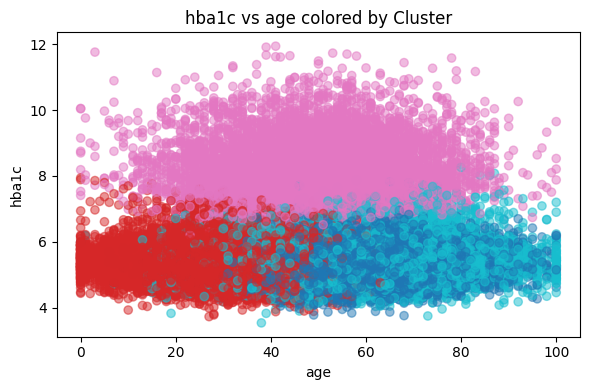

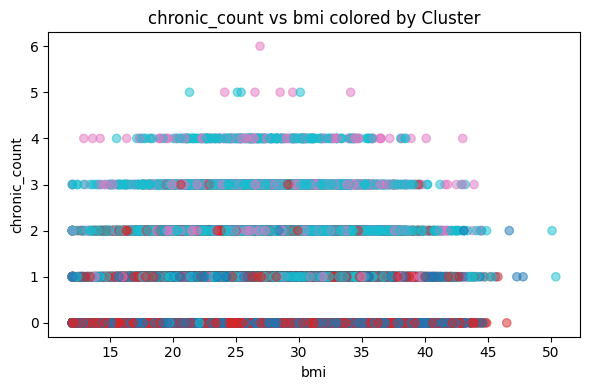

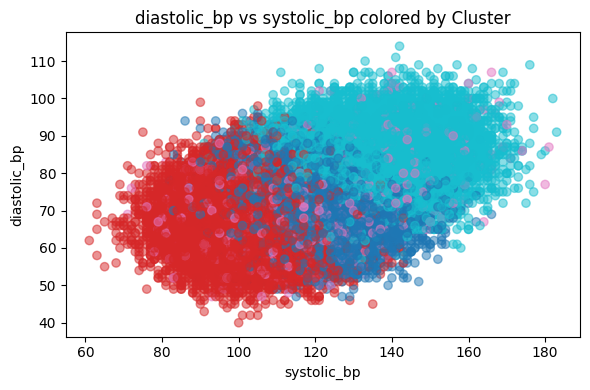

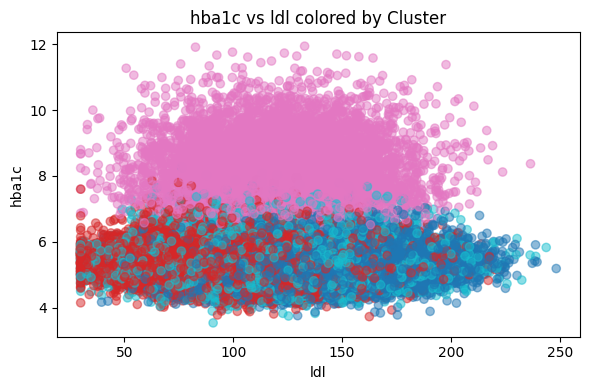

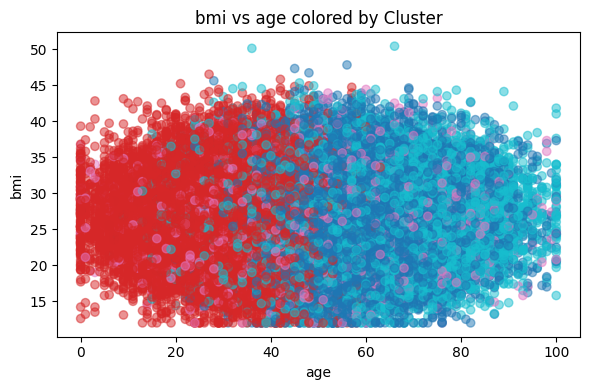

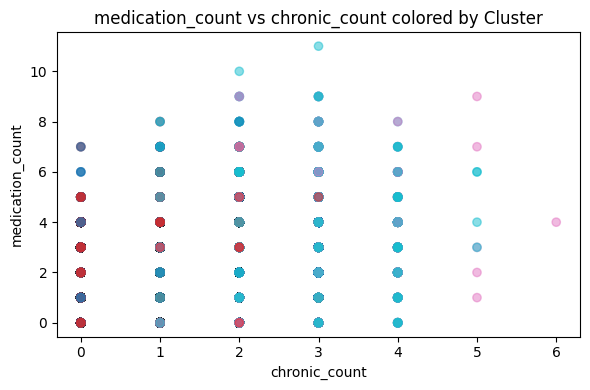

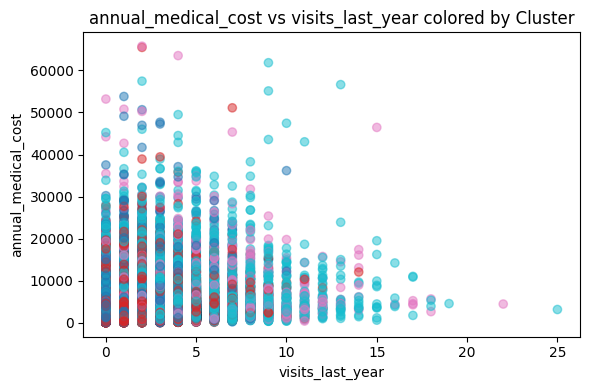

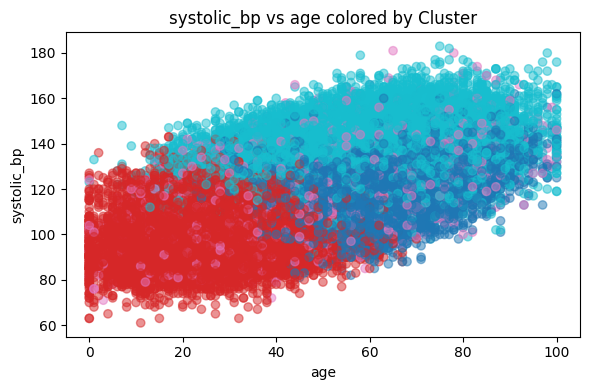

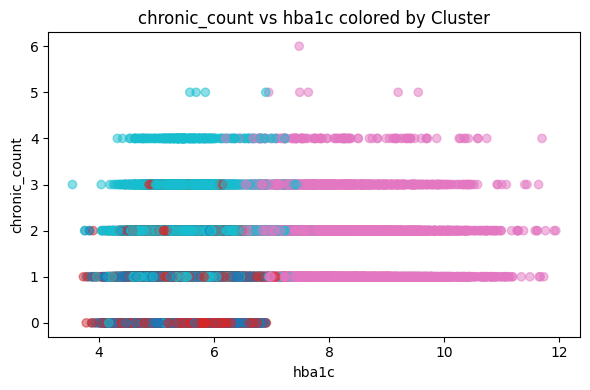

In [6]:
# cost breakdown by cluster
if "annual_medical_cost" in df.columns:
    cost_by_cluster = (
        df.groupby("cluster")["annual_medical_cost"]
          .agg(["count", "mean", "sum"])
          .rename(columns={"count": "n", "mean": "avg_cost", "sum": "total_cost"})
    )
    cost_by_cluster["cost_share_%"] = (
        100 * cost_by_cluster["total_cost"] / cost_by_cluster["total_cost"].sum()
    )
    print("\nCost by cluster:")
    print(cost_by_cluster.round(2))

# visuals
# cluster level cost comparison barplot
plt.figure(figsize=(8,5))
plt.bar(cost_by_cluster.index, cost_by_cluster["avg_cost"])
plt.xlabel("Cluster")
plt.ylabel("Average Annual Medical Cost")
plt.title("Average Medical Cost by Cluster")
plt.show()

# clsuter size barplot
plt.figure(figsize=(8,5))
plt.bar(df["cluster"].value_counts().index,
        df["cluster"].value_counts().values)
plt.xlabel("Cluster")
plt.ylabel("Number of Patients")
plt.title("Cluster Sizes")
plt.show()

# boxplots to compare how each risk factor is distributed across the patient clusters 
box_vars = ["bmi", "chronic_count", "hba1c", "visits_last_year", "medication_count", "systolic_bp", "diastolic_bp"]

for var in box_vars:
    plt.figure(figsize=(7, 4))
    df.boxplot(column=var, by="cluster")
    plt.title(f"{var} by Cluster")
    plt.suptitle("")  # fix pandas title
    plt.xticks(ticks=[1, 2, 3, 4], labels=["1", "2", "3", "4"]) # I added this to allign with our cluster numberings (to start at 1 not 0)
    plt.xlabel("Cluster")
    plt.ylabel(var)
    plt.tight_layout()
    plt.show()


# different (pair) cost indicators 
    pairs = [
    ("age", "hba1c"),
    ("bmi", "chronic_count"),
    ("systolic_bp", "diastolic_bp"),
    ("ldl", "hba1c"),
    ("age", "bmi"),
    ("chronic_count", "medication_count"),
    ("visits_last_year", "annual_medical_cost"),
    ("age", "systolic_bp"),
    ("hba1c", "chronic_count")
]

# plot for each pair (some not used in presentation)
for xvar, yvar in pairs:
    plt.figure(figsize=(6, 4))
    scatter = plt.scatter(df[xvar], df[yvar], c=df["cluster"], cmap="tab10", alpha=0.5)
    plt.xlabel(xvar)
    plt.ylabel(yvar)
    plt.title(f"{yvar} vs {xvar} colored by Cluster")
    plt.tight_layout()
    plt.show()


## 5. Supervised Validation (Random Forest)

We train a Random Forest classifier to predict the cluster labels. 
1. High accuracy implies the clusters are well-separated.
2. We extract Feature Importance to see which variables are driving the segmentation.


Random forest below

Classification Report (Cluster Prediction)
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      6972
           1       0.98      0.96      0.97      7125
           2       0.96      0.99      0.97      1311
           3       0.96      0.97      0.97      4592

    accuracy                           0.97     20000
   macro avg       0.96      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000


Confusion Matrix
[[6709  140    8  115]
 [ 186 6865   23   51]
 [   1    7 1300    3]
 [  71   18   30 4473]]


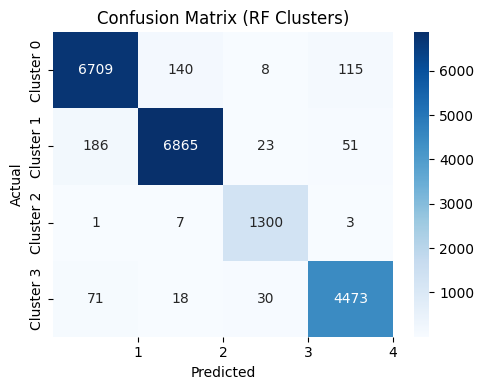

In [7]:
# random forest

print("\nRandom forest below")

# same predictors used for clustering
X_rf = df[cluster_features].copy()

# y = cluster labels from k means
y_rf = df["cluster"]

# test / train split
X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf,
    test_size=0.20,
    random_state=100,
    stratify=y_rf
)

# build pipeline
rf_med = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=250, # 250 trees
        min_samples_leaf=5, 
        class_weight="balanced",  # handle cluster imbalance
        random_state=100,
        n_jobs=-1 
    ))
])

# fit model
rf_med.fit(X_train, y_train)

# predictions
y_pred = rf_med.predict(X_test)

# evaluation
print("\nClassification Report (Cluster Prediction)")
print(classification_report(y_test, y_pred))

# prediction accuracy
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix")
print(cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Cluster {i}" for i in range(k_chose)],
            yticklabels=[f"Cluster {i}" for i in range(k_chose)])
plt.xticks(ticks=[1, 2, 3, 4], labels=["1", "2", "3", "4"]) # same as barplots... I added to match cluster numbers
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (RF Clusters)")
plt.tight_layout()
plt.show()


ROC Curves for Each Cluster


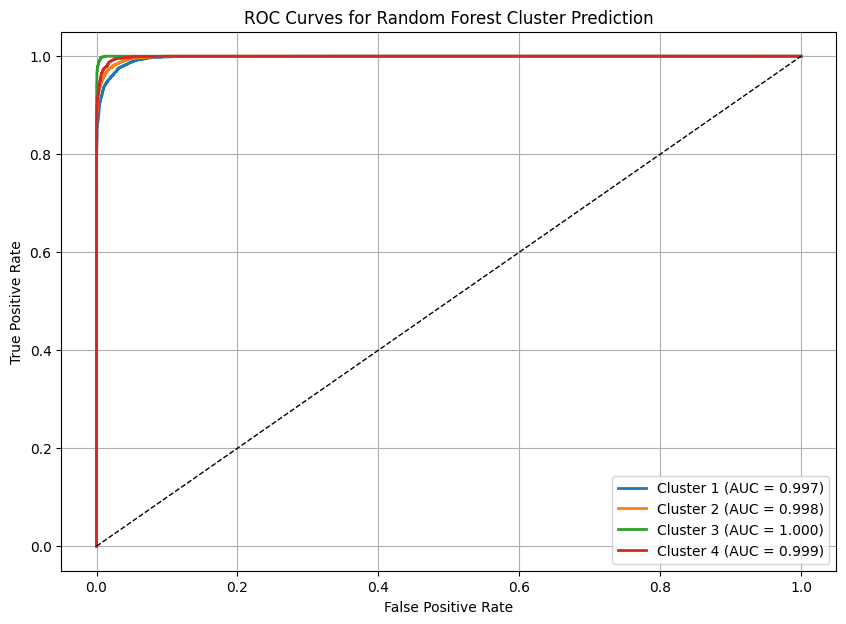

In [8]:
# ROC Curves for each cluster for further validation
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

print("\nROC Curves for Each Cluster")

# create multiclass ROC Curve
classes = [0, 1, 2, 3]
display_labels = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]

# get true labels for ROC plot
y_test_bin = label_binarize(y_test, classes=classes)

# get probability for each class
y_pred_proba = rf_med.predict_proba(X_test)

# ROC Curve Plot
plt.figure(figsize=(10, 7))

for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{display_labels[i]} (AUC = {roc_auc:.3f})")

# creates random model curve for comparison
plt.plot([0, 1], [0, 1], "k--", lw=1)

plt.title("ROC Curves for Random Forest Cluster Prediction")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [9]:
# get feature importance
# get ohe feature names for categorical predictors
ohe = rf_med.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
encoded_cat_names = ohe.get_feature_names_out(categorical_cols)

# combine with numeric feature names
all_feature_names = list(encoded_cat_names) + numeric_cols

# get importances from RF
importances = rf_med.named_steps["rf"].feature_importances_

fi_rf = (
    pd.DataFrame({"feature": all_feature_names, "importance": importances})
      .sort_values("importance", ascending=False)
)

# printing the top 20 features (for reference only)
print("\nTop 20 Cluster Features:")
print(fi_rf.head(20))


Top 20 Cluster Features:
                    feature  importance
14                    hba1c    0.350227
15            chronic_count    0.165093
11              systolic_bp    0.149773
9                       age    0.147982
12             diastolic_bp    0.112423
13                      ldl    0.061749
10                      bmi    0.007708
0                sex_Female    0.000906
1                  sex_Male    0.000896
5              smoker_Never    0.000759
7   alcohol_freq_Occasional    0.000641
4             smoker_Former    0.000576
8       alcohol_freq_Weekly    0.000555
3            smoker_Current    0.000401
6        alcohol_freq_Daily    0.000202
2                 sex_Other    0.000109


/var/folders/_v/8t1gnjyj4113x264jvhn6sb80000gn/T/ipykernel_91462/2438488.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_cost = df.groupby('age_group')['annual_medical_cost'].mean()


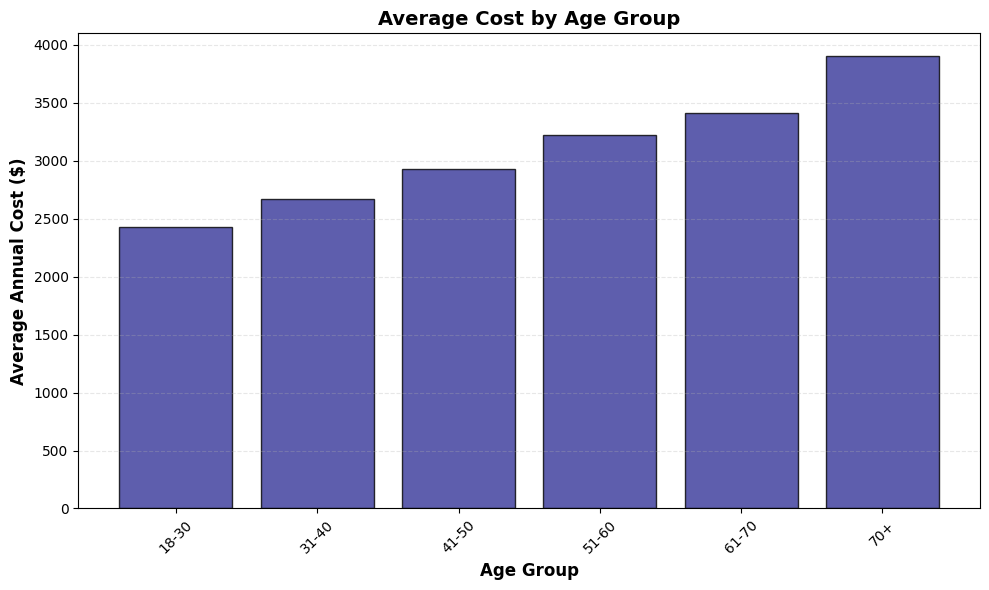

In [ ]:
# Box Plot Example. We used hardcoded boxplot code to generate all our graphs. 
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 70, 100], # change the variable, bin categories for new graphs
labels=['18-30', '31-40', '41-50', '51-60', '61-70', '70+'])
age_cost = df.groupby('age_group')['annual_medical_cost'].mean()


plt.figure(figsize=(10, 6)) # Create a single figure
bars = plt.bar(range(len(age_cost)), age_cost.values,
color="#363699", edgecolor='black', alpha=0.8)

plt.xlabel('Age Group', fontsize=12, fontweight='bold')
plt.ylabel('Average Annual Cost ($)', fontsize=12, fontweight='bold') # y-axis title
plt.title('Average Cost by Age Group', fontsize=14, fontweight='bold') # main graph title 
plt.xticks(range(len(age_cost)), labels=age_cost.index, rotation=45)
plt.grid(alpha=0.3, axis='y', linestyle='--')

# show the plot
plt.tight_layout()
plt.show()